In [1]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from plotnine import *
from xgboost import *
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import numpy as np
import Functions

In [2]:
train_size = 0.75
val_size = 0.10
test_size = 0.15

y_train, y_val, y_test, X_train, X_val, X_test = Functions.getSplittedData(['Charge', 'Mass', 'NumAtoms', 'FractionSP3', 'NumRotatableBonds', 'Length'], train_size, val_size, test_size)

In [3]:
m1 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
m1.fit(X_train, y_train.ravel())

y_pred = m1.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")


Mean Squared Error: 0.00035143363453623156
Mean Absolute Error: 0.010859895633930847
R² Score: 0.9907428588275182


In [10]:
hyperparams = m1.get_params()
params = pd.DataFrame(hyperparams.items(), columns=['parameter', 'value'])
params

,parameter,value
0,objective,reg:squarederror
1,base_score,None
2,booster,None
3,callbacks,None
4,colsample_bylevel,None
5,colsample_bynode,None
6,colsample_bytree,None
7,device,None
8,early_stopping_rounds,None
9,enable_categorical,False


14405
Percentage of data with deviation > 20%: 10.54%
Max Deviation: [167533.2]%
True Value (Max Deviation): [3.3649479e-06]
Predicted Value (Max Deviation): 0.00565752200782299
Index of Max Deviation: 9023
Min Deviation: [-44424.4]%
True Value (Min Deviation): [-1.065023e-05]
Predicted Value (Min Deviation): 0.004716206341981888
Index of Min Deviation: 2894


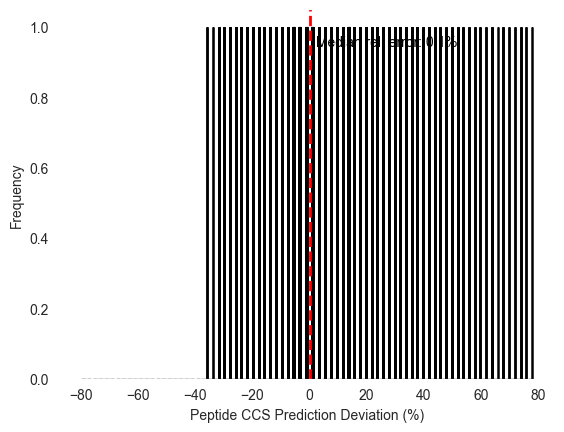

In [20]:
# Example data (replace with actual data)
predictions = y_pred
true_values= y_val
print(len(true_values))

# Compute deviations
deviation = [(b - a) / (a + 1e-8) * 100 for a, b in zip(true_values, predictions)]

# Round deviations
deviation_percentage_rounded = np.round(deviation, 1)

deviations_above_20 = sum(1 for d in deviation_percentage_rounded if abs(d) > 20)

# Calculate the percentage of data with deviation higher than 50%
percentage_above_20 = (deviations_above_20 / len(deviation_percentage_rounded)) * 100

print(f"Percentage of data with deviation > 20%: {percentage_above_20:.2f}%")

max_deviation_idx = np.argmax(deviation_percentage_rounded)
min_deviation_idx = np.argmin(deviation_percentage_rounded)
# Print summary
print(f"Max Deviation: {deviation_percentage_rounded[max_deviation_idx]}%")
print(f"True Value (Max Deviation): {true_values[max_deviation_idx]}")
print(f"Predicted Value (Max Deviation): {predictions[max_deviation_idx]}")
print(f"Index of Max Deviation: {max_deviation_idx}")

print(f"Min Deviation: {deviation_percentage_rounded[min_deviation_idx]}%")
print(f"True Value (Min Deviation): {true_values[min_deviation_idx]}")
print(f"Predicted Value (Min Deviation): {predictions[min_deviation_idx]}")
print(f"Index of Min Deviation: {min_deviation_idx}")


sorted_deviations = sorted(deviation_percentage_rounded)

# Calculate the index for the 5% threshold
lower_5_percent_index = int(len(sorted_deviations) * 0.01)
upper_5_percent_index = int(len(sorted_deviations) * 0.99)

# Filter out the top and bottom 5% of the data
filtered_deviations = sorted_deviations[lower_5_percent_index:upper_5_percent_index]
median_error = np.median(sorted_deviations)
# Plot the histogram with the filtered data
plt.hist(filtered_deviations, bins=np.arange(-80, 80, 2), edgecolor='black')

plt.axvline(median_error, color='red', linestyle='dashed', linewidth=2, label=f'Median Error: {median_error:.1f}%')

# Annotate the median value with the text "Median Error: {median_error}"
plt.text(median_error + 2, plt.ylim()[1] * 0.9, f'Median rel. error: {median_error:.1f}%', color='black', fontsize=10)

ax = plt.gca()  # Get the current axes
ax.set_facecolor("white")
# Labels and title
plt.xlabel('Peptide CCS Prediction Deviation (%)')
plt.ylabel('Frequency')

# Show plot
plt.savefig('XGB deviation plot.png')
plt.show()

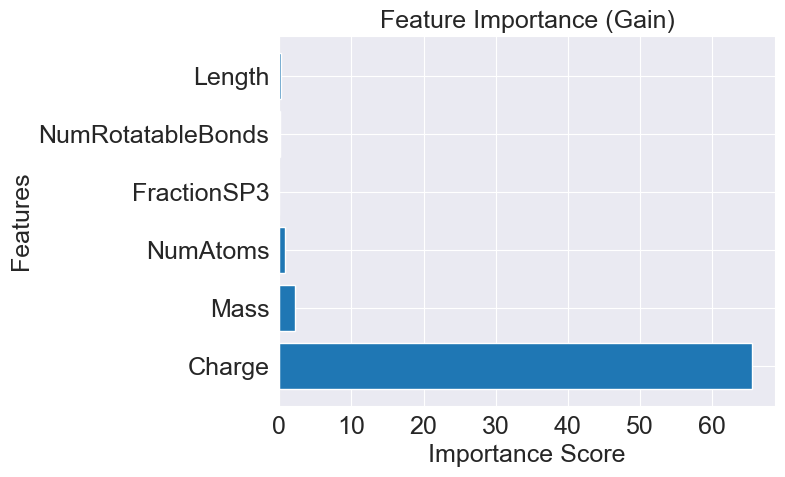

In [21]:
importance = m1.get_booster().get_score(importance_type='gain')

importance_rounded = {k: round(v, 4) for k, v in importance.items()}

importance_array = np.array(list(importance_rounded.values()))
feature_names = list(importance_rounded.keys())

plt.barh(feature_names, importance_array)
plt.title('Feature Importance (Gain)',fontsize=18)
plt.xlabel('Importance Score', fontsize=18)
plt.ylabel('Features', fontsize=18)
plt.xticks(fontsize=18)                             
plt.yticks(fontsize=18) 
plt.savefig('XGB importance gain.png')
plt.show()

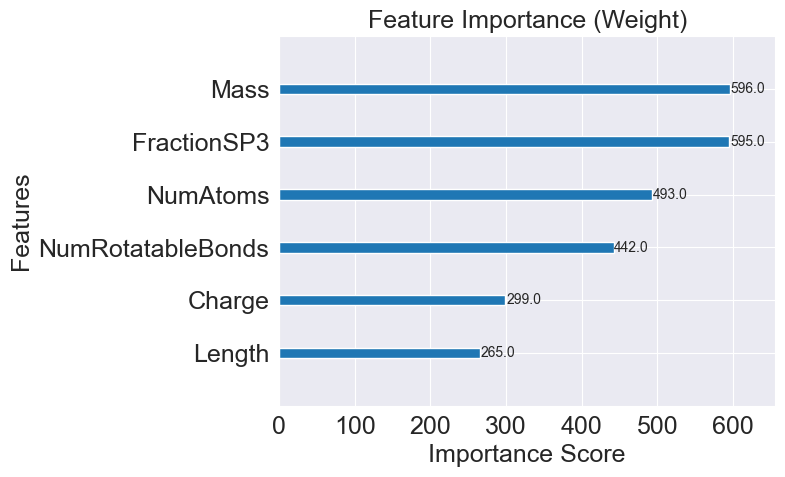

In [22]:
plot_importance(m1, importance_type='weight')
plt.title('Feature Importance (Weight)', fontsize=18)
plt.xlabel('Importance Score', fontsize=18)
plt.ylabel('Features', fontsize=18)
plt.xticks(fontsize=18) 
plt.yticks(fontsize=18)
plt.savefig('XGB importance weight.png')
plt.show()

In [23]:
importances = m1.feature_importances_
feature_names = ['Charge', 'Mass', 'Length', 'NumRotatableBonds', 'NumAtoms', 'FractionSP3']

feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
0,Charge,0.950901
1,Mass,0.032765
2,Length,0.011358
5,FractionSP3,0.003937
4,NumAtoms,0.000872
3,NumRotatableBonds,0.000166


In [66]:
features =['Charge', 'Mass']
m2 = XGBRegressor()
param_grid = {
    'n_estimators': [ 500, 900, 1000, 1200],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5],
    'max_leaves': [1, 2, 3, 4, 5, 6, 7],
    'subsample': [0.7, 0.8, 0.9],
}
grid_search = HalvingGridSearchCV(m2, param_grid, cv=5, scoring='r2', random_state=42)
grid_search.fit(X_train[features], y_train.ravel())
grid_search.best_params_

{'learning_rate': 0.01,
 'max_depth': 5,
 'max_leaves': 5,
 'min_child_weight': 1,
 'n_estimators': 1200,
 'subsample': 0.9}

In [69]:
y_pred_fin = grid_search.predict(X_test[features])
mse_fin = mean_squared_error(y_test, y_pred_fin)
mae_fin = mean_absolute_error(y_test, y_pred_fin)
r2_fin = r2_score(y_test, y_pred_fin)
print(f"Mean Squared Error: {mse_fin}")
print(f"Mean Absolute Error: {mae_fin}")
print(f"R² Score: {r2_fin}")

Mean Squared Error: 0.0003918910284559623
Mean Absolute Error: 0.011644666106577013
R² Score: 0.9897101605245912


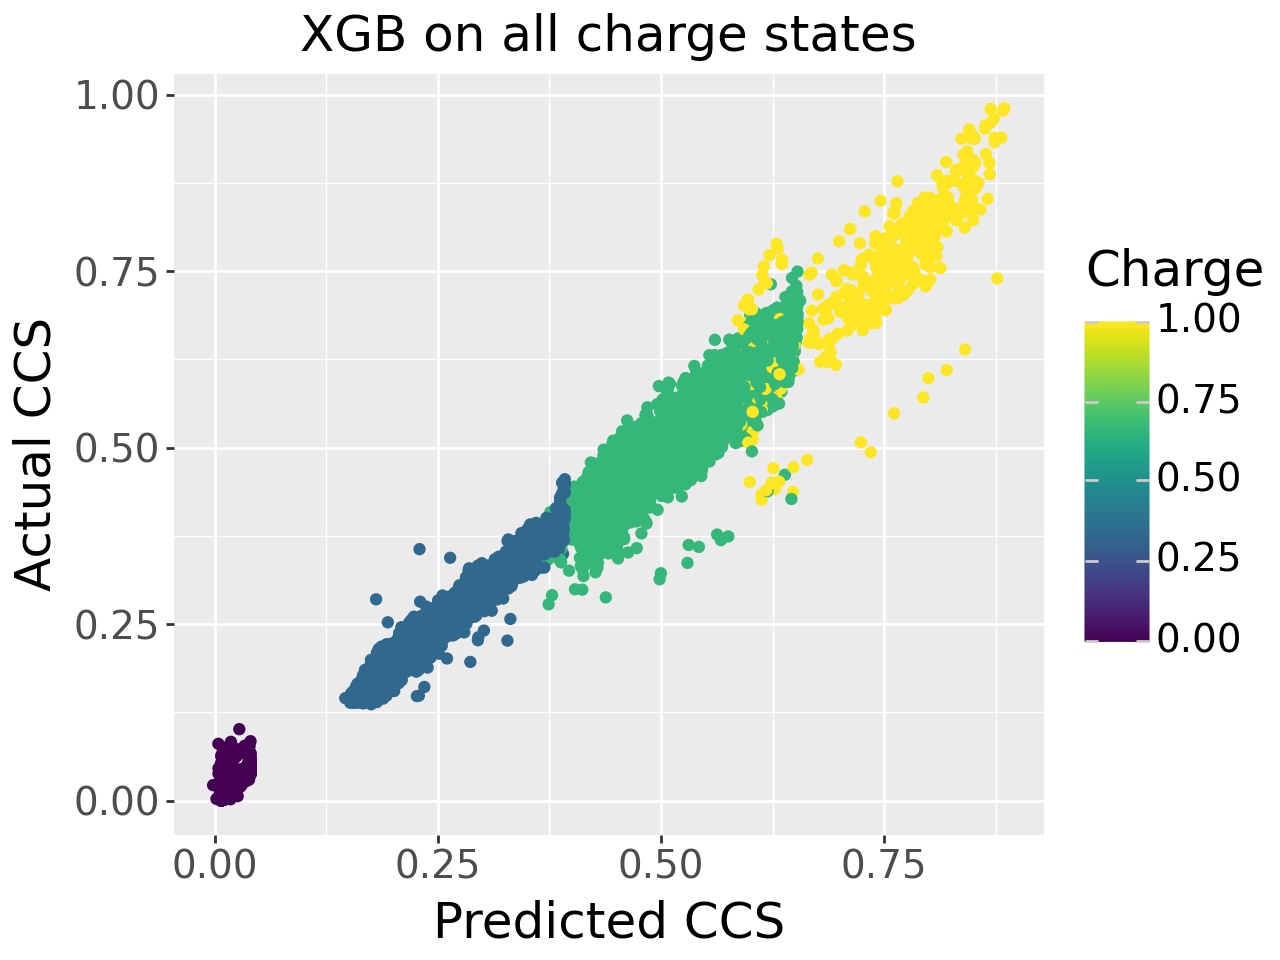

In [75]:
df= pd.DataFrame()
df['Charge'] = X_test['Charge']
df['CCS_pred'] = y_pred_fin
df['CCS_actual'] = y_test
plot1 = (
    ggplot(df, aes(x = "CCS_pred", y = "CCS_actual", color="Charge"))
    +  labs(y = "Actual CCS", x = "Predicted CCS", title="Final XGB Regressor")
    + geom_point() 
    + theme(
        plot_title=element_text(size=18),         # Schriftgröße des Titels
        axis_title_x=element_text(size=18),       # Schriftgröße der X-Achsenbeschriftung
        axis_title_y=element_text(size=18),       # Schriftgröße der Y-Achsenbeschriftung
        legend_title=element_text(size=18), 
        axis_text_x=element_text(size=14),        # X-axis tick label font size
        axis_text_y=element_text(size=14), # Schriftgröße des Legendentitels
        legend_text=element_text(size=14)         # Schriftgröße des Legendentextes
    )
)
plot1.save(filename='XGB.png', dpi=300)
plot1.show()

In [20]:
# All of the following code is only experimental, looking at the idea of building models for each charge state but we didn't spent much time working on this idea
features_c = ['Mass', 'Length', 'NumAtoms', 'FractionSP3', 'NumRotatableBonds']

In [29]:
# Daten einlesen
data = pd.read_csv('RandomForest Datenset 1.csv', sep='\t')

# Splitte den DataFrame nach Charge
grouped_by_charge = data.groupby("Charge")

# Funktion zur Aufteilung von Trainings-, Validierungs- und Testdaten für jede Charge
def split_charge_data(charge_group, val_size=0.1, test_size=0.2, random_state=42):
    # Splitte in Trainings- und Testdaten
    train_data, test_data = train_test_split(charge_group, test_size=test_size, random_state=random_state)
    # Optional: Splitte Trainingsdaten in Trainings- und Validierungsdaten
    train_data, val_data = train_test_split(
        train_data, 
        test_size=val_size / (1 - test_size),  # Proportion für Validation
        random_state=random_state
    )
    return train_data, val_data, test_data

# Leere Dictionaries für X und y
X_train_dict = {}
y_train_dict = {}
X_val_dict = {}
y_val_dict = {}
X_test_dict = {}
y_test_dict = {}

# Iteriere über jede Charge, teile sie in train, val, test und speichere sie
for charge, charge_group in grouped_by_charge:
    # Aufteilen der Daten für jede Charge
    train, val, test = split_charge_data(charge_group)
    
    # Separate Scaler für Features und Zielvariable
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    # Speichere die DataFrames für jede Charge
    X_train_dict[charge] = scaler_X.fit_transform(train[features_c].to_numpy())  # X-Features skalieren
    y_train_dict[charge] = scaler_y.fit_transform(train['CCS'].values.reshape(-1, 1) * 1e40)  # y-Ziel skalieren
    
    X_val_dict[charge] = scaler_X.transform(val[features_c].to_numpy())  # X-Features skalieren
    y_val_dict[charge] = scaler_y.transform(val['CCS'].values.reshape(-1, 1) * 1e40)  # y-Ziel skalieren
    
    X_test_dict[charge] = scaler_X.transform(test[features_c].to_numpy())  # X-Features skalieren
    y_test_dict[charge] = scaler_y.transform(test['CCS'].values.reshape(-1, 1) * 1e40)  # y-Ziel skalieren


In [37]:
print(y_train_dict[1].max())

0.9999999999999999


In [38]:
mc1 = XGBRegressor()
mc1.fit(X_train_dict[1], y_train_dict[1])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [39]:
y_pred_c1 = mc1.predict(X_test_dict[1])
mse_c1 = mean_squared_error(y_test_dict[1], y_pred_c1)
r2_c1 = r2_score(y_test_dict[1], y_pred_c1)
mae_c1 = mean_absolute_error(y_test_dict[1], y_pred_c1)

print(f"Mean Squared Error: {mse_c1}")
print(f"Mean Absolute Error: {mae_c1}")
print(f"R² Score: {r2_c1}")

Mean Squared Error: 0.0013370240798578634
Mean Absolute Error: 0.016877559235946412
R² Score: 0.6555390445432725


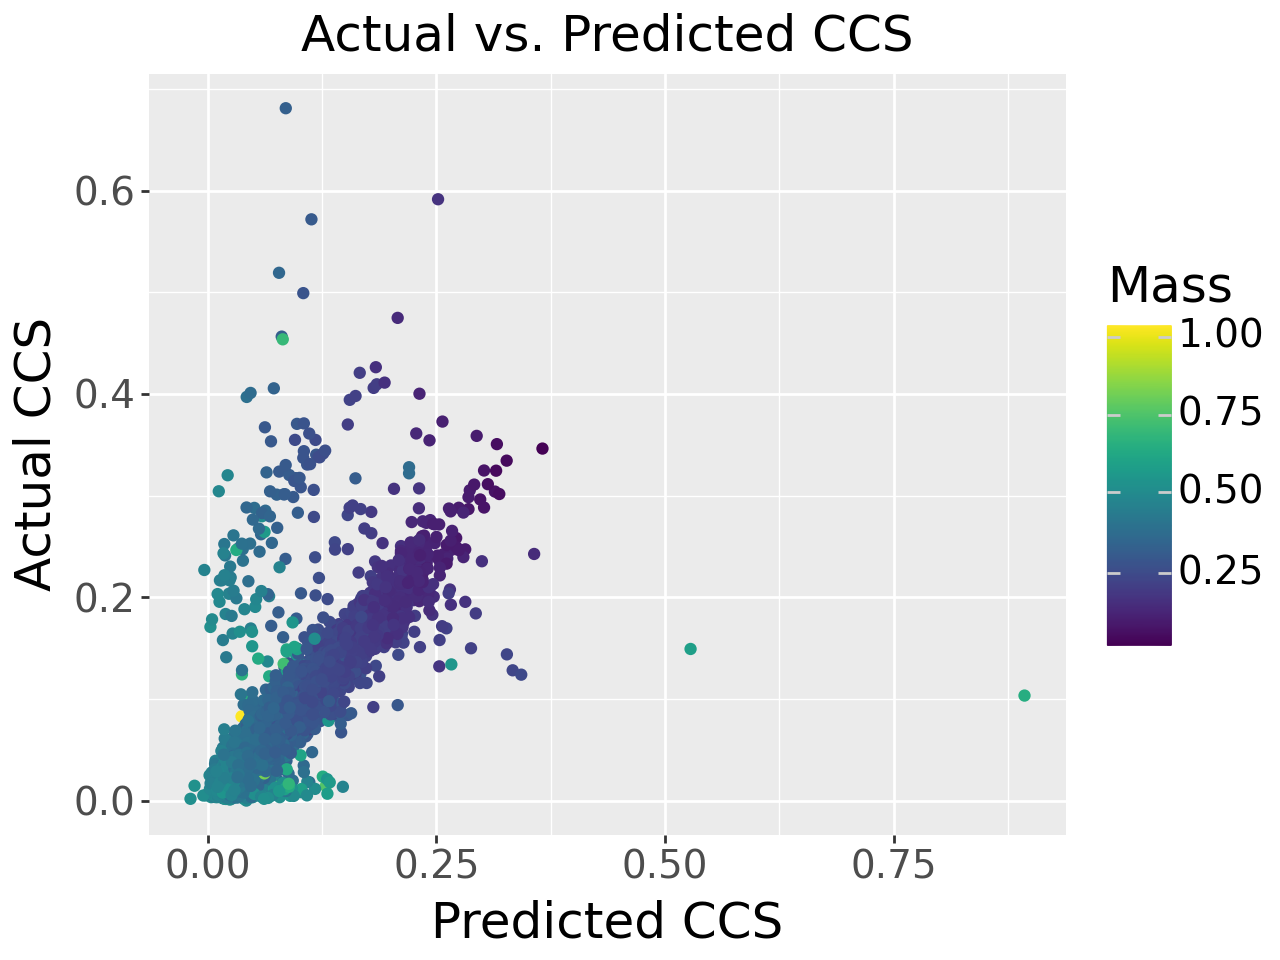

In [42]:
df= pd.DataFrame()
df_t1 = pd.DataFrame(X_test_dict[1], columns=features_c)
df['Mass'] = df_t1['Mass']
df['CCS_pred'] = y_pred_c1
df['CCS_actual'] = y_test_dict[1]
plot_c1 = (
    ggplot(df, aes(x = "CCS_pred", y = "CCS_actual", color="Mass"))
    +  labs(y = "Actual CCS", x = "Predicted CCS", title="Actual vs. Predicted CCS")
    + geom_point() 
    + theme(
        plot_title=element_text(size=18),         # Schriftgröße des Titels
        axis_title_x=element_text(size=18),       # Schriftgröße der X-Achsenbeschriftung
        axis_title_y=element_text(size=18),       # Schriftgröße der Y-Achsenbeschriftung
        legend_title=element_text(size=18), 
        axis_text_x=element_text(size=14),        # X-axis tick label font size
        axis_text_y=element_text(size=14), # Schriftgröße des Legendentitels
        legend_text=element_text(size=14)         # Schriftgröße des Legendentextes
    )
)
#plot1.save(filename='C:/Users/samue/OneDrive/Desktop/Ion mobility/XGB.png', dpi=300)
plot_c1.show()

In [44]:
m_c1 = XGBRegressor()
param_grid_c1 = {
    'n_estimators': [ 500, 900, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5],
    'max_leaves': [1, 2, 3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
}
grid_search = HalvingGridSearchCV(m_c1, param_grid, cv=5, scoring='r2', random_state=42)
grid_search.fit(X_train_dict[1], y_train_dict[1])
grid_search.best_params_

C:\Users\samue\PycharmProjects\PBL_Ion_Mobility\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast


{'learning_rate': 0.01,
 'max_depth': 7,
 'max_leaves': 3,
 'min_child_weight': 4,
 'n_estimators': 900,
 'subsample': 0.7}

In [47]:
y_pred_c1f = grid_search.predict(X_test_dict[1])
mse_c1f = mean_squared_error(y_test_dict[1], y_pred_c1f)
r2_c1f = r2_score(y_test_dict[1], y_pred_c1f)
mae_c1f = mean_absolute_error(y_test_dict[1], y_pred_c1f)

print(f"Mean Squared Error: {mse_c1f}")
print(f"Mean Absolute Error: {mae_c1f}")
print(f"R² Score: {r2_c1f}")

Mean Squared Error: 0.0012153623905738192
Mean Absolute Error: 0.017093879368279732
R² Score: 0.6868830587346373


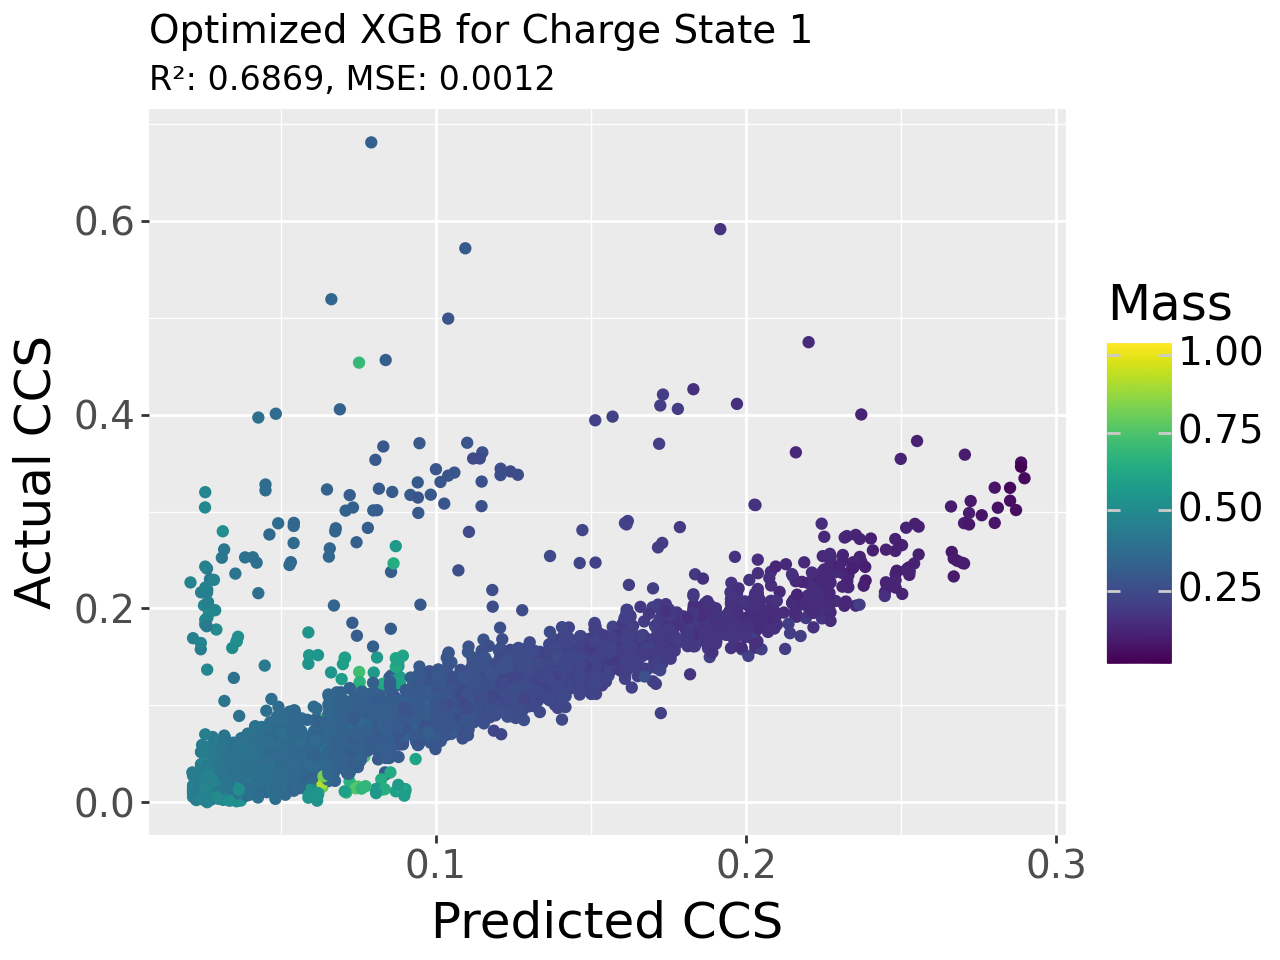

In [54]:
df= pd.DataFrame()
df_t1 = pd.DataFrame(X_test_dict[1], columns=features_c)
df['Mass'] = df_t1['Mass']
df['CCS_pred'] = y_pred_c1f
df['CCS_actual'] = y_test_dict[1]
plot_c1 = (
    ggplot(df, aes(x = "CCS_pred", y = "CCS_actual", color="Mass"))
    +  labs(y = "Actual CCS", x = "Predicted CCS", title="Optimized XGB for Charge State 1", subtitle="R²: 0.6869, MSE: 0.0012")
    + geom_point() 
    + theme(
        plot_title=element_text(size=14),          # Schriftgröße des Titels
        plot_subtitle=element_text(size=12),
        axis_title_x=element_text(size=18),       # Schriftgröße der X-Achsenbeschriftung
        axis_title_y=element_text(size=18),       # Schriftgröße der Y-Achsenbeschriftung
        legend_title=element_text(size=18), 
        axis_text_x=element_text(size=14),        # X-axis tick label font size
        axis_text_y=element_text(size=14), # Schriftgröße des Legendentitels
        legend_text=element_text(size=14)         # Schriftgröße des Legendentextes
    )
)
#plot1.save(filename='XGB_charge1.png', dpi=300)
plot_c1.show()

Mean Squared Error: 0.0008442534830770176
Mean Absolute Error: 0.021281646298087015
R² Score: 0.9711676460744302


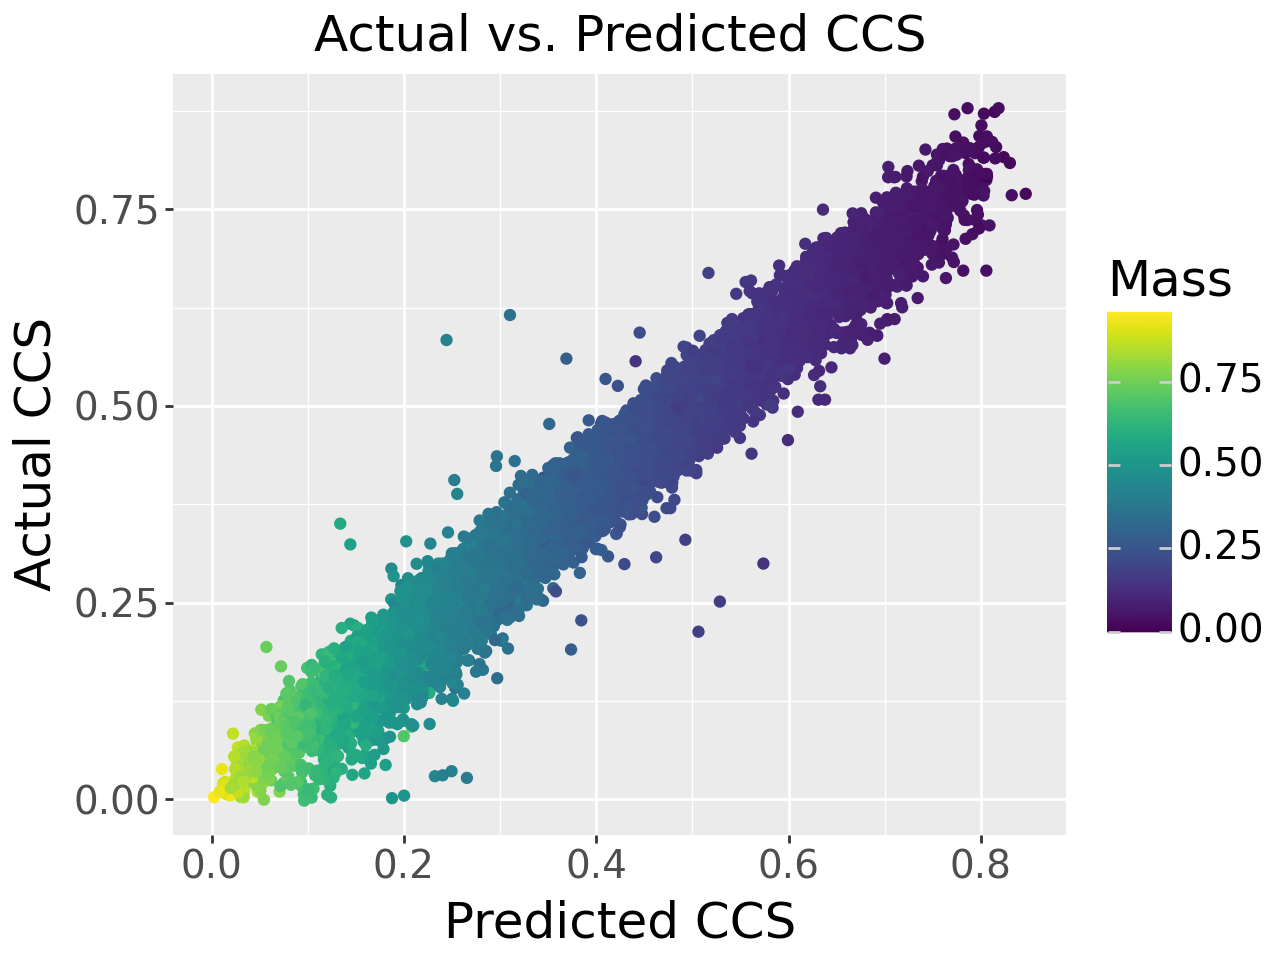

In [56]:
mc2 = XGBRegressor()
mc2.fit(X_train_dict[2], y_train_dict[2])
y_pred_c2 = mc2.predict(X_test_dict[2])
mse_c2 = mean_squared_error(y_test_dict[2], y_pred_c2)
r2_c2 = r2_score(y_test_dict[2], y_pred_c2)
mae_c2 = mean_absolute_error(y_test_dict[2], y_pred_c2)

print(f"Mean Squared Error: {mse_c2}")
print(f"Mean Absolute Error: {mae_c2}")
print(f"R² Score: {r2_c2}")

df= pd.DataFrame()
df_t2 = pd.DataFrame(X_test_dict[2], columns=features_c)
df['Mass'] = df_t2['Mass']
df['CCS_pred'] = y_pred_c2
df['CCS_actual'] = y_test_dict[2]
plot_c1 = (
    ggplot(df, aes(x = "CCS_pred", y = "CCS_actual", color="Mass"))
    +  labs(y = "Actual CCS", x = "Predicted CCS", title="Actual vs. Predicted CCS")
    + geom_point() 
    + theme(
        plot_title=element_text(size=18),         # Schriftgröße des Titels
        axis_title_x=element_text(size=18),       # Schriftgröße der X-Achsenbeschriftung
        axis_title_y=element_text(size=18),       # Schriftgröße der Y-Achsenbeschriftung
        legend_title=element_text(size=18), 
        axis_text_x=element_text(size=14),        # X-axis tick label font size
        axis_text_y=element_text(size=14), # Schriftgröße des Legendentitels
        legend_text=element_text(size=14)         # Schriftgröße des Legendentextes
    )
)
#plot1.save(filename='C:/Users/samue/OneDrive/Desktop/Ion mobility/XGB.png', dpi=300)
plot_c1.show()

Mean Squared Error: 0.0055726774357597675
Mean Absolute Error: 0.05908509325825957
R² Score: 0.8145010794002406


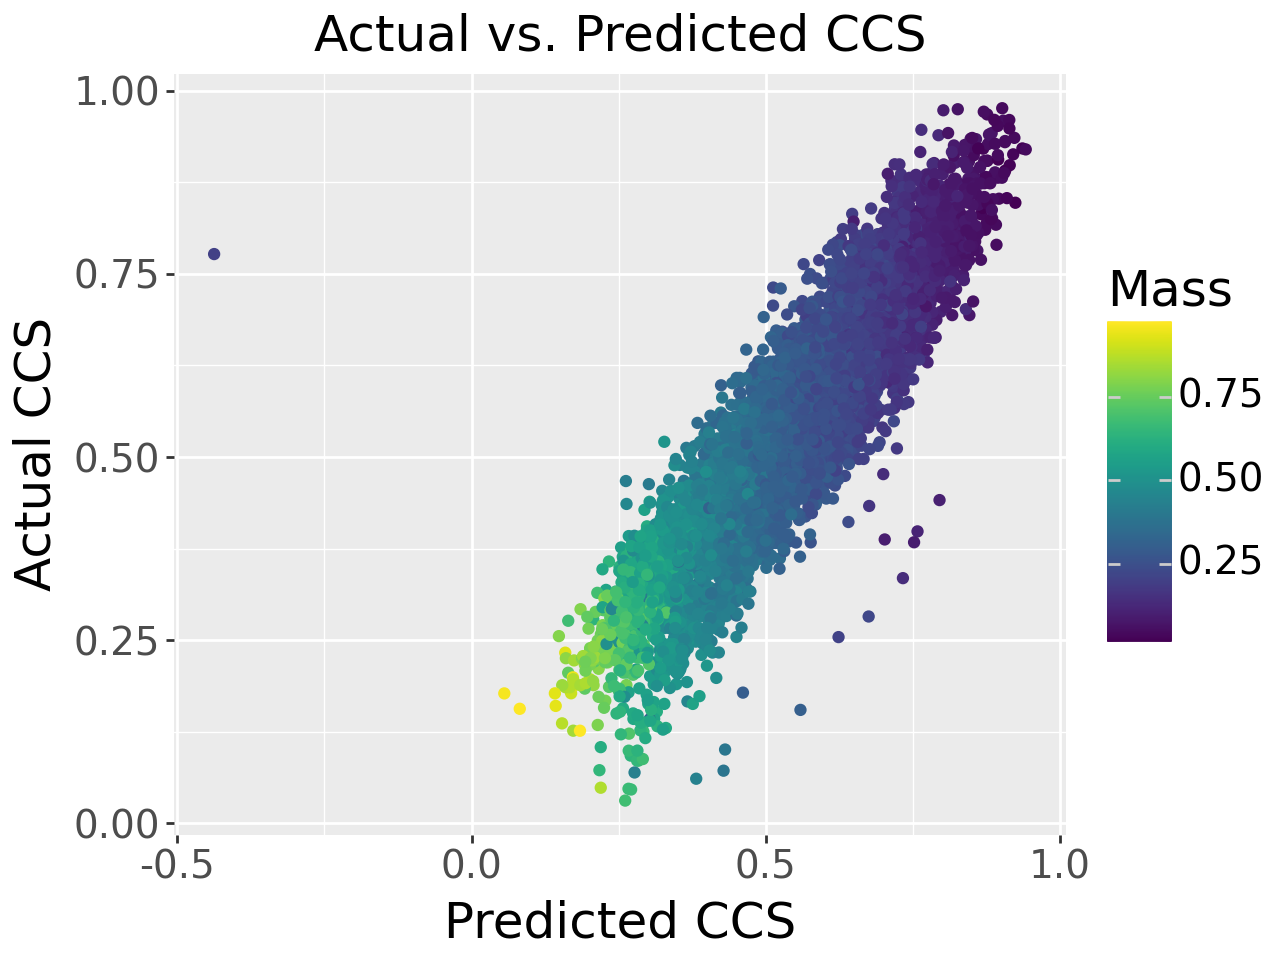

In [58]:
mc3 = XGBRegressor()
mc3.fit(X_train_dict[3], y_train_dict[3])
y_pred_c3 = mc3.predict(X_test_dict[3])
mse_c3 = mean_squared_error(y_test_dict[3], y_pred_c3)
r2_c3 = r2_score(y_test_dict[3], y_pred_c3)
mae_c3 = mean_absolute_error(y_test_dict[3], y_pred_c3)

print(f"Mean Squared Error: {mse_c3}")
print(f"Mean Absolute Error: {mae_c3}")
print(f"R² Score: {r2_c3}")

df = pd.DataFrame()
df_t3 = pd.DataFrame(X_test_dict[3], columns=features_c)
df['Mass'] = df_t3['Mass']
df['CCS_pred'] = y_pred_c3
df['CCS_actual'] = y_test_dict[3]

plot_c3 = (
    ggplot(df, aes(x="CCS_pred", y="CCS_actual", color="Mass"))
    + labs(y="Actual CCS", x="Predicted CCS", title="Actual vs. Predicted CCS")
    + geom_point()
    + theme(
        plot_title=element_text(size=18),
        axis_title_x=element_text(size=18),
        axis_title_y=element_text(size=18),
        legend_title=element_text(size=18),
        axis_text_x=element_text(size=14),
        axis_text_y=element_text(size=14),
        legend_text=element_text(size=14),
    )
)
#plot_c3.save(filename='C:/Users/samue/OneDrive/Desktop/Ion mobility/XGB_3.png', dpi=300)
plot_c3.show()


Mean Squared Error: 0.008858241710095228
Mean Absolute Error: 0.06728071946897793
R² Score: 0.7123432990218109


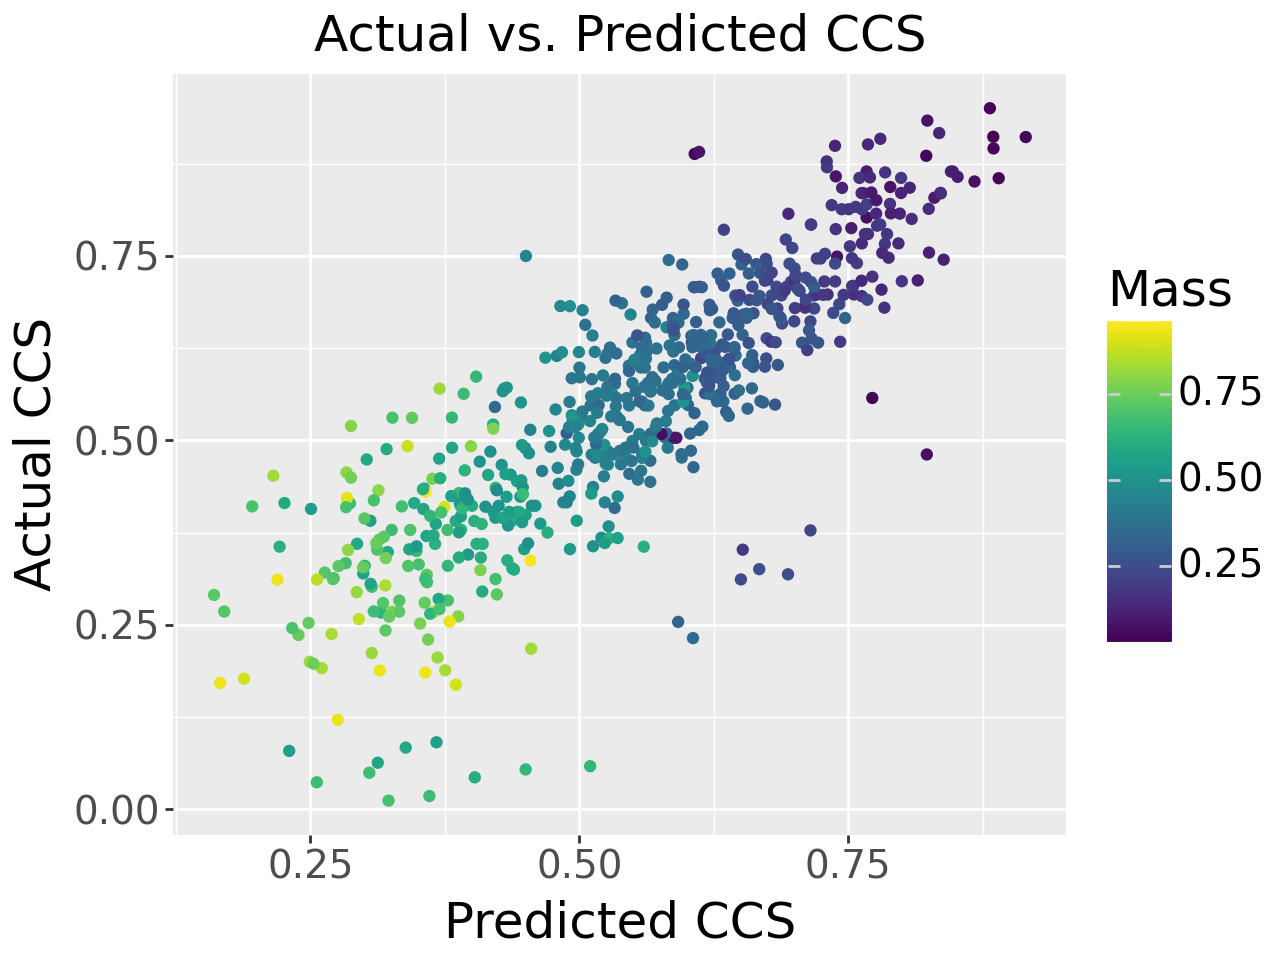

In [59]:
mc4 = XGBRegressor()
mc4.fit(X_train_dict[4], y_train_dict[4])
y_pred_c4 = mc4.predict(X_test_dict[4])
mse_c4 = mean_squared_error(y_test_dict[4], y_pred_c4)
r2_c4 = r2_score(y_test_dict[4], y_pred_c4)
mae_c4 = mean_absolute_error(y_test_dict[4], y_pred_c4)

print(f"Mean Squared Error: {mse_c4}")
print(f"Mean Absolute Error: {mae_c4}")
print(f"R² Score: {r2_c4}")

df = pd.DataFrame()
df_t4 = pd.DataFrame(X_test_dict[4], columns=features_c)
df['Mass'] = df_t4['Mass']
df['CCS_pred'] = y_pred_c4
df['CCS_actual'] = y_test_dict[4]

plot_c4 = (
    ggplot(df, aes(x="CCS_pred", y="CCS_actual", color="Mass"))
    + labs(y="Actual CCS", x="Predicted CCS", title="Actual vs. Predicted CCS")
    + geom_point()
    + theme(
        plot_title=element_text(size=18),
        axis_title_x=element_text(size=18),
        axis_title_y=element_text(size=18),
        legend_title=element_text(size=18),
        axis_text_x=element_text(size=14),
        axis_text_y=element_text(size=14),
        legend_text=element_text(size=14),
    )
)
#plot_c4.save(filename='C:/Users/samue/OneDrive/Desktop/Ion mobility/XGB_4.png', dpi=300)
plot_c4.show()
